In [45]:
import pandas as pd

valid_market_df = pd.read_excel("/Users/pranavlakhotia/Downloads/Quant_Research_Project_TB/valid_market_df.xlsx")

valid_market_df

,time,banknifty,nifty,tte
0,2021-01-01 09:15:00,0.286058,0.199729,27
1,2021-01-01 09:16:00,0.285381,0.200433,27
2,2021-01-01 09:17:00,0.284233,0.200004,27
3,2021-01-01 09:18:00,0.286104,0.199860,27
4,2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...,...
113536,2022-06-30 15:26:00,0.240701,0.214758,28
113537,2022-06-30 15:27:00,0.240875,0.216558,28
113538,2022-06-30 15:28:00,0.242115,0.216794,28
113539,2022-06-30 15:29:00,0.243426,0.216455,28


In [46]:
valid_market_df['spread'] = valid_market_df['banknifty'] - valid_market_df['nifty']
display(valid_market_df)

,time,banknifty,nifty,tte,spread
0,2021-01-01 09:15:00,0.286058,0.199729,27,0.086329
1,2021-01-01 09:16:00,0.285381,0.200433,27,0.084948
2,2021-01-01 09:17:00,0.284233,0.200004,27,0.084229
3,2021-01-01 09:18:00,0.286104,0.199860,27,0.086244
4,2021-01-01 09:19:00,0.285539,0.198951,27,0.086588
...,...,...,...,...,...
113536,2022-06-30 15:26:00,0.240701,0.214758,28,0.025943
113537,2022-06-30 15:27:00,0.240875,0.216558,28,0.024317
113538,2022-06-30 15:28:00,0.242115,0.216794,28,0.025321
113539,2022-06-30 15:29:00,0.243426,0.216455,28,0.026971


In [47]:
# Expanding mean (μ_t)
valid_market_df['mu'] = valid_market_df['spread'].expanding(min_periods=1).mean()

# Expanding standard deviation (σ_t)
valid_market_df['sigma'] = valid_market_df['spread'].expanding(min_periods=2).std()

# Z-score (Z_t)
valid_market_df['zscore'] = (valid_market_df['spread'] - valid_market_df['mu']) / valid_market_df['sigma']

display(valid_market_df)

,time,banknifty,nifty,tte,spread,mu,sigma,zscore
0,2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.086329,NaN,NaN
1,2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.085639,0.000976,-0.707107
2,2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.085169,0.001067,-0.880656
3,2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.085437,0.001024,0.787325
4,2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.085668,0.001025,0.897906
...,...,...,...,...,...,...,...,...
113536,2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.072337,0.026704,-1.737338
113537,2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.072336,0.026704,-1.798213
113538,2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.072336,0.026704,-1.760565
113539,2022-06-30 15:29:00,0.243426,0.216455,28,0.026971,0.072336,0.026705,-1.698749


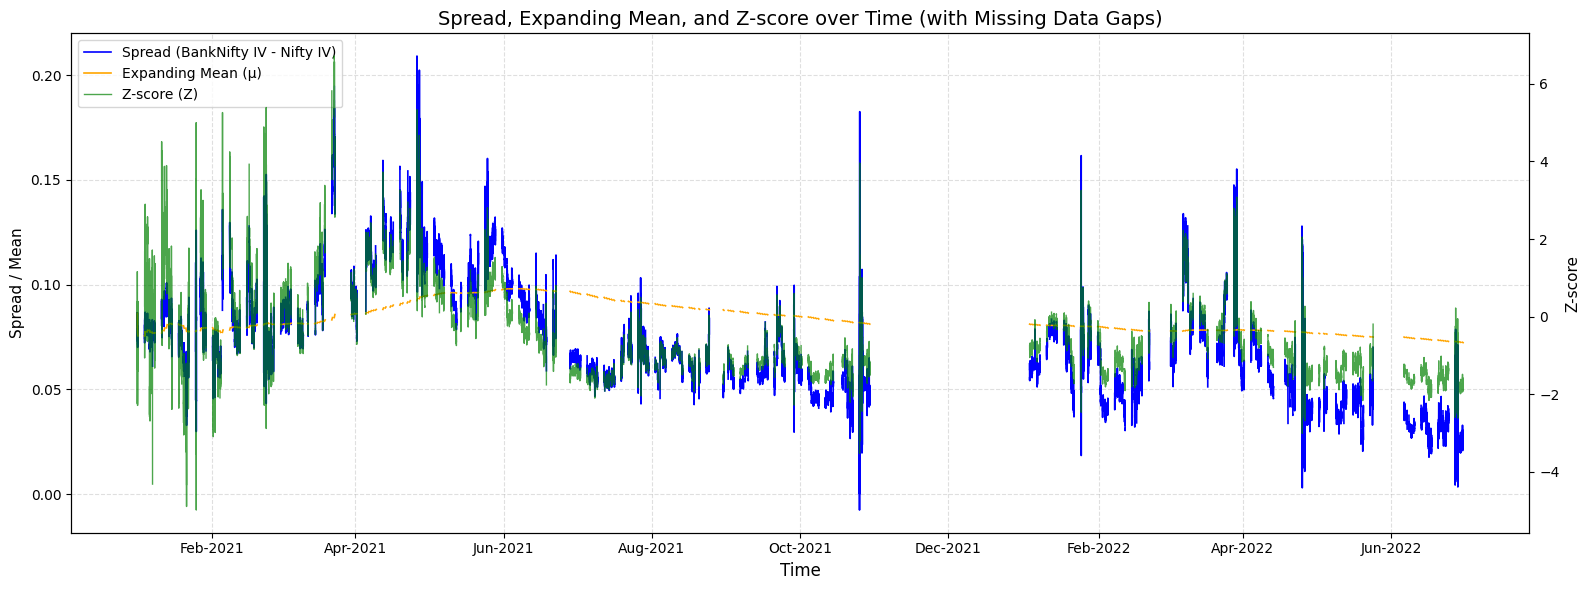

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

plt.figure(figsize=(16,6))
ax1 = plt.gca()

# Ensure time column is sorted and continuous gaps are preserved
valid_market_df = valid_market_df.sort_values('time').reset_index(drop=True)

# Convert time to datetime index for easier handling
df_plot = valid_market_df.set_index('time')

# Introduce NaNs explicitly where large time gaps exist (>2 minutes)
# (you can adjust threshold if needed)
time_diff = df_plot.index.to_series().diff().dt.total_seconds().fillna(0)
gap_threshold = 120  # seconds
df_plot.loc[time_diff > gap_threshold, ['spread', 'mu', 'zscore']] = np.nan

# --- Primary axis ---
ax1.plot(df_plot.index, df_plot['spread'], color='blue', label='Spread (BankNifty IV - Nifty IV)', linewidth=1.2)
ax1.plot(df_plot.index, df_plot['mu'], color='orange', label='Expanding Mean (μ)', linewidth=1.2)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Spread / Mean', fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.4)

# --- Secondary axis for z-score ---
ax2 = ax1.twinx()
ax2.plot(df_plot.index, df_plot['zscore'], color='green', label='Z-score (Z)', linewidth=1, alpha=0.7)
ax2.set_ylabel('Z-score', fontsize=11)

# --- Formatting ---
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=45)

# --- Combine legends ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Spread, Expanding Mean, and Z-score over Time (with Missing Data Gaps)', fontsize=14)
plt.tight_layout()
plt.show()

In [49]:
# Complete example using tanh mapping (recommended)
import numpy as np
import pandas as pd

df = valid_market_df.copy().reset_index(drop=True)

k = 0.65
P = 1.0

# mapping
g = np.tanh(k * (-df['zscore'])).fillna(0)

scale = df['tte'] ** 0.7
raw_bnk = g * scale
raw_nifty = -g * scale

abs_notional = (raw_bnk.abs() * df['banknifty'].abs()) + (raw_nifty.abs() * df['nifty'].abs())
abs_notional = abs_notional.replace(0, np.nan).fillna(1.0)

w_bnk = raw_bnk / abs_notional
w_nifty = raw_nifty / abs_notional

df['dollar_bnk'] = w_bnk * P
df['dollar_nifty'] = w_nifty * P

# Optional cap on each leg
cap = 0.5  # at most 50% of portfolio in absolute allocation for any leg
df['dollar_bnk'] = df['dollar_bnk'].clip(-cap, cap)
df['dollar_nifty'] = df['dollar_nifty'].clip(-cap, cap)

# Compute PL using previous allocations
df['delta_bnk'] = df['banknifty'].diff().fillna(0)
df['delta_nifty'] = df['nifty'].diff().fillna(0)

df['PL_port'] = df['dollar_bnk'].shift(1).fillna(0) * df['delta_bnk'] + df['dollar_nifty'].shift(1).fillna(0) * df['delta_nifty']
df['PL_port'] = df['PL_port'].fillna(0)

# Cumulate (use additive or multiplicative depending on magnitude; additive is fine since numbers are small)
df['cum_PL'] = df['PL_port'].cumsum()
df['cum_value'] = 1 + df['cum_PL']

# Simple metrics (minute-level)
mean_ret = df['PL_port'].mean()
std_ret = df['PL_port'].std()
# if you want annualized Sharpe from minute PLs (not normalized by capital), you can:
minutes_per_year = 252 * 390
sharpe_min = (mean_ret / std_ret) * np.sqrt(minutes_per_year) if std_ret != 0 else np.nan

# Daily aggregation (recommended) to compute realistic Sharpe and drawdown
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
daily_pl = df['PL_port'].resample('1D').sum()
daily_pl = daily_pl[daily_pl != 0]  # remove zero-no-trade days if desired

capital = 1.0  # since P=1
daily_return = daily_pl / capital
mean_daily = daily_return.mean(); std_daily = daily_return.std(ddof=1)
sharpe_daily = (mean_daily / std_daily) * np.sqrt(252) if std_daily != 0 else np.nan
cum_return = (1 + daily_return).cumprod()
if not cum_return.empty:
    rolling_max = cum_return.cummax()
    drawdown = cum_return / rolling_max - 1
    max_dd = drawdown.min()
else:
    max_dd = np.nan

print("minute Sharpe (approx):", sharpe_min)
print("daily Sharpe:", sharpe_daily)
print("max drawdown:", max_dd)


minute Sharpe (approx): 13.951785678601098
daily Sharpe: 3.1612397156273055
max drawdown: -0.027937275108249948


In [41]:
# Step 2️⃣ : Compute notional normalization factor
df['norm_factor'] = np.abs(df['w_bnk_scaled'] * df['banknifty']) + np.abs(df['w_nifty_scaled'] * df['nifty'])
df['w_bnk_norm'] = np.where(df['norm_factor'] != 0, df['w_bnk_scaled'] / df['norm_factor'], 0)
df['w_nifty_norm'] = np.where(df['norm_factor'] != 0, df['w_nifty_scaled'] / df['norm_factor'], 0)

In [42]:
# Step 3️⃣ : Compute minute returns for each IV
df['ret_bnk'] = df['banknifty'].pct_change().fillna(0)
df['ret_nifty'] = df['nifty'].pct_change().fillna(0)

# Portfolio return = weighted sum of individual returns
df['port_ret'] = df['w_bnk_norm'].shift(1) * df['ret_bnk'] + df['w_nifty_norm'].shift(1) * df['ret_nifty']
df['port_ret'] = df['port_ret'].fillna(0)

In [43]:
# Step 4️⃣ : Compute cumulative portfolio value
df['cum_value'] = (1 + df['port_ret']).cumprod()

# Total P/L
total_pl = df['cum_value'].iloc[-1] - 1

# Sharpe ratio (annualized)
minute_per_year = 252 * 390  # ~252 trading days * 390 minutes
sharpe = (df['port_ret'].mean() / df['port_ret'].std()) * np.sqrt(minute_per_year)

# Max drawdown
cum_max = df['cum_value'].cummax()
drawdown = df['cum_value'] / cum_max - 1
max_dd = drawdown.min()

In [44]:
print(f"Total Cumulative Return: {total_pl*100:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe:.3f}")
print(f"Max Drawdown: {max_dd*100:.2f}%")

Total Cumulative Return: 789748695462213443058556438841083793021861888.00%
Annualized Sharpe Ratio: 12.886
Max Drawdown: -100.00%


In [26]:
valid_market_df['daily_return'] = valid_market_df['PL_money'] / notional

In [27]:
mean_return = valid_market_df['daily_return'].mean()
std_return = valid_market_df['daily_return'].std()

In [28]:
sharpe_ratio = (mean_return / std_return) * np.sqrt(252)

In [29]:
valid_market_df['cum_return'] = (1 + valid_market_df['daily_return']).cumprod() - 1

In [32]:
rolling_max = valid_market_df['cum_return'].cummax()
drawdown = (cum_return - rolling_max) / rolling_max
max_drawdown = drawdown.min()

NameError: name 'cum_return' is not defined

In [31]:
print(f"Total Cumulative P/L (₹): {valid_market_df['cum_PL_money'].iloc[-1]:.2f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Max Drawdown: {max_drawdown:.3%}")

Total Cumulative P/L (₹): 30827810.82
Annualized Sharpe Ratio: 0.861
Max Drawdown: -inf%


In [33]:
import numpy as np
import pandas as pd

# ---- ASSUMPTIONS ----
# valid_market_df must have 'time' (datetime-like) and 'PL_money' (minute-level P/L in currency)
# Choose portfolio capital against which returns are measured:
capital = 1_000_000.0  # example: ₹1,000,000 (change as needed)

# Make sure time is datetime and set as index
valid_market_df['time'] = pd.to_datetime(valid_market_df['time'])
valid_market_df = valid_market_df.set_index('time').sort_index()

# 1) Cumulative P/L (money) at minute level
valid_market_df['cum_PL_money'] = valid_market_df['PL_money'].cumsum()

# 2) Aggregate to daily P/L (sum minute P/L per calendar day)
#    Use business/market days only; remove days with zero activity if needed
daily_PL = valid_market_df['PL_money'].resample('1D').sum()

# Optionally drop days with zero trading (if you expect no activity on weekends)
daily_PL = daily_PL[daily_PL != 0]  # keep only days with some P/L; or use .dropna()

# 3) Daily return = daily_PL / capital
daily_return = daily_PL / capital
daily_return = daily_return.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# 4) Performance metrics
mean_daily = daily_return.mean()
std_daily = daily_return.std(ddof=1)

# Guard against zero std (no variation)
if std_daily == 0 or np.isnan(std_daily):
    sharpe_ratio = np.nan
else:
    sharpe_ratio = mean_daily / std_daily * np.sqrt(252)

# 5) Cumulative return (start at 1)
cum_return = (1 + daily_return).cumprod()
# If cum_return has no entries (empty), handle gracefully
if cum_return.shape[0] == 0:
    max_drawdown = np.nan
else:
    rolling_max = cum_return.cummax()
    drawdown = (cum_return - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

# 6) Final monetary numbers
total_PL_money = valid_market_df['PL_money'].sum()
final_portfolio_value = capital * cum_return.iloc[-1] if cum_return.shape[0] > 0 else capital + total_PL_money

# 7) Print nicely
print(f"Assumed capital: {capital:,.0f}")
print(f"Total cumulative P/L (₹): {total_PL_money:,.2f}")
print(f"Final portfolio value (₹): {final_portfolio_value:,.2f}")
print(f"Annualized Sharpe Ratio (daily): {sharpe_ratio:.4f}")
if isinstance(max_drawdown, float) and not np.isnan(max_drawdown):
    print(f"Max Drawdown: {max_drawdown:.2%}")
else:
    print("Max Drawdown: NaN (insufficient data)")


Assumed capital: 1,000,000
Total cumulative P/L (₹): 30,827,810.82
Final portfolio value (₹): 43,712,086,418,020.51
Annualized Sharpe Ratio (daily): 3.3628
Max Drawdown: -0.90%
